In [ ]:
import pandas as pd
import ast

In [ ]:
import pickle
with open('../artifacts/genre_mappings.pkl', "rb") as f:
        genre_map = pickle.load(f)

In [ ]:
df = pd.read_csv('../data/prompt_golden_data.csv')[['processed_lyrics', 'genres']]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data, _, _ = train_test_split(df, df['genres'], test_size=0.10, random_state=42)

In [ ]:
import datasets

In [ ]:
train_data = datasets.Dataset.from_pandas(train_data)
test_data = datasets.Dataset.from_pandas(test_data)

In [ ]:
len(genre_map['genre_to_idx'].keys())

In [ ]:
train_data

In [ ]:
len(genre_map['genre_to_idx'])

In [ ]:
import transformers

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_and_numericalize_example(example, tokenizer):
    tokens = tokenizer(example["processed_lyrics"], truncation=True, padding=True)
    label = [0] * len(genre_map['genre_to_idx'])
    for genre in ast.literal_eval(example['genres']):
        label[genre_map['genre_to_idx'][genre]] = 1
    return {"ids": tokens["input_ids"], "label": label, 'attention_mask': tokens["attention_mask"]}

In [ ]:
train_data = train_data.map(tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer})

In [ ]:
test_data = test_data.map(tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer})

In [ ]:
pad_index = tokenizer.pad_token_id

In [ ]:
# Convert arrays to torch Tensor
train_data = train_data.with_format(type="torch", columns=["ids", "label", "attention_mask"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [ ]:
from data import get_data

In [ ]:
train, _ = get_data('bert-base-uncased', 128)

In [ ]:
train

In [1]:
import torch

In [2]:
x = torch.randn([4,10])

In [3]:
x.shape

torch.Size([4, 10])

In [4]:
s = torch.nn.Sigmoid()

In [5]:
y = s(x)

In [6]:
y_true = torch.zeros(x.shape)

In [7]:
y_true

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
y

tensor([[0.1487, 0.3887, 0.4114, 0.7052, 0.7016, 0.4686, 0.4337, 0.3477, 0.2962,
         0.7124],
        [0.6341, 0.6618, 0.3480, 0.7105, 0.2981, 0.5656, 0.1338, 0.3991, 0.2576,
         0.7751],
        [0.7182, 0.3442, 0.4415, 0.3915, 0.5278, 0.7290, 0.1916, 0.5829, 0.5348,
         0.2324],
        [0.5745, 0.8534, 0.6622, 0.8903, 0.3728, 0.6731, 0.5165, 0.6784, 0.5498,
         0.5989]])

In [9]:
criteria = torch.nn.BCELoss()

In [10]:
criteria(y_true, y)

tensor(51.1535)

In [11]:
from torchmetrics import Accuracy

In [17]:
multiclass_accuracy  = Accuracy(threshold=0.5, task='multilabel',num_labels=10)

In [18]:
multiclass_accuracy(y,y_true)

tensor(0.4500)

In [1]:
from src.data import get_data
from src.model import load_model

In [2]:
train_data, _ = get_data('bert-base-uncased', 1)

Map:   0%|          | 0/8109 [00:00<?, ? examples/s]

Map:   0%|          | 0/902 [00:00<?, ? examples/s]

In [3]:
model = load_model('bert-base-uncased', True)

In [4]:
for batch in train_data:
    output = model(batch['ids'], batch['attention_masks'])
    print(batch.keys())
    break

dict_keys(['ids', 'label', 'attention_masks'])


In [5]:
import torch

In [6]:
loss_criteria = torch.nn.BCELoss()

In [9]:
loss_criteria(torch.nn.functional.sigmoid(output), batch['label'])

tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward0>)

In [10]:
loss_criteria(torch.nn.functional.sigmoid(output), batch['label'])*output.shape[1]

tensor(769.6158, grad_fn=<MulBackward0>)

In [11]:
loss_criteria = torch.nn.BCEWithLogitsLoss()

In [12]:
loss_criteria(output, batch['label'])

tensor(0.6933, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [35]:
output

tensor([[0.0005, 0.0002, 0.0002,  ..., 0.0003, 0.0075, 0.0020]],
       grad_fn=<SigmoidBackward0>)

In [40]:
output[:, 91]

tensor([0.0529], grad_fn=<SelectBackward0>)

In [41]:
batch['label'][:, 91]

tensor([1.])

In [43]:
(output >= 0.5).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [42]:
(batch['label'] == 1.).nonzero(as_tuple=False)

tensor([[   0,   91],
        [   0,  211],
        [   0,  695],
        [   0,  892],
        [   0, 1075]])

In [13]:
from torchmetrics import Accuracy

In [14]:
multilabel_accuracy  = Accuracy(threshold=0.5, task='multilabel',num_labels=1110)

In [20]:
temp = torch.ones_like(output)

In [21]:
multilabel_accuracy(temp, batch['label'])

tensor(0.0036)

In [38]:
torch.argmax(output)

tensor(211)

In [39]:
torch.argmax(batch['label'])

tensor(91)

In [22]:
import pickle

In [23]:
with open('artifacts/genre_mappings.pkl', "rb") as f:
        genre_map = pickle.load(f)

In [24]:
genre_map

{'idx_to_genre': {0: 'etherpop',
  1: 'ohio hip hop',
  2: 'new age',
  3: 'lovers rock',
  4: 'deep underground hip hop',
  5: 'modern dream pop',
  6: 'el paso indie',
  7: 'anti-folk',
  8: 'post-post-hardcore',
  9: 'charlottesville indie',
  10: 'swedish synthpop',
  11: 'neo classical metal',
  12: 'retro soul',
  13: 'post-rock',
  14: 'funk rock',
  15: 'paisley underground',
  16: 'gospel antigas',
  17: 'country gospel',
  18: 'rennes indie',
  19: 'danish metal',
  20: 'cartoon',
  21: 'persian pop',
  22: 'indie surf',
  23: 'canadian hip hop',
  24: 'political hip hop',
  25: 'axe',
  26: 'mizrahi',
  27: 'dayton indie',
  28: 'vancouver indie',
  29: 'chicago house',
  30: 'uk funky',
  31: 'dfw rap',
  32: 'swamp pop',
  33: 'funk pop',
  34: 'shimmer pop',
  35: 'belgian edm',
  36: 'wrestling',
  37: 'alternative country',
  38: 'instrumental surf',
  39: 'nottingham indie',
  40: 'indy indie',
  41: 'brazilian power metal',
  42: 'oc indie',
  43: 'spanish pop',
  44:

In [25]:
import pandas as pd

In [33]:
df = pd.read_csv('data/lyrics_classifier/cleaned_test_lyrics.csv')[['Lyric', 'genre']]

In [34]:
df.shape

(50000, 2)

In [35]:
df.columns

Index(['Lyric', 'genre'], dtype='object')

<Axes: >

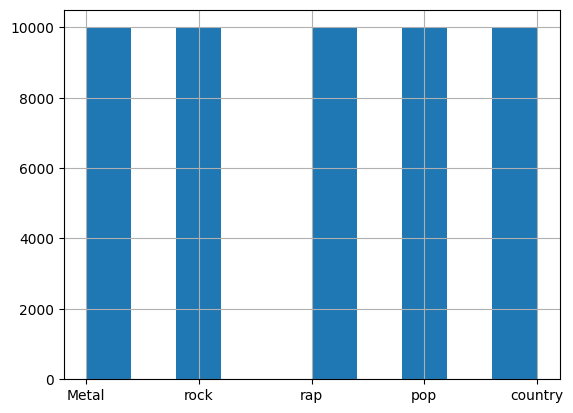

In [37]:
df['genre'].hist()

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_data, test_data, _, _ = train_test_split(df, df['genre'], test_size=0.20, random_state=42, stratify=df['genre'])

In [42]:
df['genre'].unique()

array(['Metal', 'rock', 'rap', 'pop', 'country'], dtype=object)

In [1]:
from src.data import get_data

In [2]:
train_data, _ = get_data('bert-base-uncased', 2)

/Users/shri/Documents/ESDS/Semester_3/Natural_Language_Processing/Project/genere_classifier/src/data.py:101: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['genre'] = df['genre'].replace(genre_map)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
from src.model import load_model

In [4]:
model = load_model('bert-base-uncased', True)

In [6]:
for batch in train_data:
    print(batch['ids'].shape)
    print(batch['label'].shape)
    print(batch['attention_masks'].shape)
    print(batch.keys())
    output = model(batch['ids'], batch['attention_masks'])
    print(output.shape)
    break

torch.Size([2, 216])
torch.Size([2])
torch.Size([2, 216])
dict_keys(['ids', 'label', 'attention_masks'])
torch.Size([2, 5])
